In [2]:
from datetime import date
import pickle

USER = 'Nunzio'
LOSS = 'mean_squared_error'
METRIC = 'MEE'
RUNTIME = date.today().strftime("%Y-%m-%d")


In [3]:
import sys
import os

if (colab := 'google.colab' in sys.modules):
    from google.colab import drive
    drive.mount('/content/drive')
    BASE_PATH = "drive/MyDrive/Colab_Notebooks/ML/machine-learning-project"   
    sys.path.insert(0,BASE_PATH)
    N_JOBS = -1
    sys.path.insert(0,BASE_PATH + "/src/utils")
    !pip install optuna
    !pip install scikit-learn
    !pip install plotly
    !pip install scikeras
    TRAIN_DATA = os.path.join(BASE_PATH, 'datasets', 'cup2023','ML-CUP23-TR.csv')
    IMAGES_FOLDER = os.path.join(BASE_PATH, 'images', 'cup2023', 'neural_network')
    MODEL_FOLDER = os.path.join(BASE_PATH, 'trained_models', 'cup2023')
else :
    N_JOBS = -1
    TRAIN_DATA = os.path.join('..', '..', 'datasets', 'cup2023', 'ML-CUP23-TR.csv')
    IMAGES_FOLDER = os.path.join('..', '..', 'images', 'cup2023', 'neural_network')
    MODEL_FOLDER = os.path.join('..', '..', 'trained_models', 'cup2023')

In [4]:
if (colab := 'google.colab' in sys.modules):
    sys.path.append(BASE_PATH + '/src/utils')
else:
    sys.path.append('../utils')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(style='darkgrid')
from keras import backend as K


from utils import save_plot, mean_euclidean_error, root_mean_squared_error, multidim_r2, set_random_state, mean_squared_error,save_optuna_study
from NN import NeuralNetwork
from joblib import dump

set_random_state(42)

/Users/nunzio/miniforge3/envs/ML23/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# To skip the first column (row indexes)
columns_to_read = list(range(1, 14))

df_train = pd.read_csv(TRAIN_DATA, header=None, comment='#', usecols=columns_to_read, delimiter=',')
df_train = df_train.astype('float64') # casting
df_train.head()

1         2         3         4         5         6         7   \
0 -0.917280 -0.712727 -0.989904  0.992819  0.993649  0.995543  0.711074   
1 -0.858784  0.998755 -0.998396  0.999909  0.316503 -0.951897 -0.163139   
2 -0.990441  0.958726 -0.998675  0.997216  0.987166  0.356483 -0.279689   
3  0.937117  0.984474 -0.612420  0.999812  0.728623 -0.539962 -0.165939   
4 -0.906628 -0.884567 -0.932487  0.941037  0.978134  0.998179  0.749606   

         8         9         10         11         12         13  
0  0.407645 -0.688548  0.616890   7.897453 -35.936382  21.077147  
1  0.980982  0.661759 -0.800155  -9.330632  19.901571   6.069154  
2  0.599163 -0.684630  0.922901  14.849400   3.374090  19.667479  
3  0.999352 -0.921444 -0.974766 -46.591854  13.734777  17.953600  
4 -0.590599 -0.508268  0.691798   8.217500 -45.885254  14.894251

In [6]:
features = ['feature_' + str(i) for i in range(1, 11)]
targets = ['target_x', 'target_y', 'target_z']

# Rename columns
new_column_names = features + targets
df_train.columns = new_column_names

df_train.head()

feature_1  feature_2  feature_3  feature_4  feature_5  feature_6  \
0  -0.917280  -0.712727  -0.989904   0.992819   0.993649   0.995543   
1  -0.858784   0.998755  -0.998396   0.999909   0.316503  -0.951897   
2  -0.990441   0.958726  -0.998675   0.997216   0.987166   0.356483   
3   0.937117   0.984474  -0.612420   0.999812   0.728623  -0.539962   
4  -0.906628  -0.884567  -0.932487   0.941037   0.978134   0.998179   

   feature_7  feature_8  feature_9  feature_10   target_x   target_y  \
0   0.711074   0.407645  -0.688548    0.616890   7.897453 -35.936382   
1  -0.163139   0.980982   0.661759   -0.800155  -9.330632  19.901571   
2  -0.279689   0.599163  -0.684630    0.922901  14.849400   3.374090   
3  -0.165939   0.999352  -0.921444   -0.974766 -46.591854  13.734777   
4   0.749606  -0.590599  -0.508268    0.691798   8.217500 -45.885254   

    target_z  
0  21.077147  
1   6.069154  
2  19.667479  
3  17.953600  
4  14.894251

In [7]:
from sklearn.model_selection import train_test_split

X = df_train[features].to_numpy()
y = df_train[targets].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_val, X_valid, y_train_val, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Create model

In [8]:
from sklearn.metrics import make_scorer

mee_scorer = make_scorer(mean_euclidean_error, greater_is_better=False)
rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)
multidim_r2_scorer = make_scorer(multidim_r2, greater_is_better=True)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

scoring = {'MEE': mee_scorer, 'R2': multidim_r2_scorer, 'RMSE': rmse_scorer, 'MSE': mse_scorer}


In [ ]:
from sklearn.model_selection import cross_val_score
import optuna
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=42)


def objective_function(trial):
    num_layers = trial.suggest_int('num_layers', 1, 5)

    # Setting up the architecture with a funnel structure
    max_units = 512
    architecture = []
    for i in range(num_layers):
        units = trial.suggest_int(f'num_units_l{i}', 32, max_units, step=32)
        architecture.append(units)
        max_units = units  # Next layer will have equal or fewer units

    dropout_input_rate = trial.suggest_float('dropout_input_rate', 0.0, 0.5)
    dropout_hidden_rate = [trial.suggest_float(f'dropout_rate_l{i}', 0.0, 0.5) for i in range(num_layers)]
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    momentum = trial.suggest_float('momentum', 0.0, 1.0)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    use_nesterov = trial.suggest_categorical('use_nesterov', [True, False])
    epochs = trial.suggest_int('epochs', 5, 400)
    batch_size = trial.suggest_int('batch_size', 16, 128)
    patience = trial.suggest_int('patience', 5, 10)





    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('model', NeuralNetwork(verbose=0, input_dimension = 10, output_dimension = 3, architecture = architecture,
                                        activation = 'relu',
                                        dropout_input_rate = dropout_input_rate,
                                        dropout_hidden_rate = dropout_hidden_rate,
                                        learning_rate = learning_rate,
                                        momentum = momentum,
                                        weight_decay = weight_decay,
                                        use_nesterov = use_nesterov,
                                        patience = patience,
                                        epochs = epochs,
                                        batch_size = batch_size,
                                        early = False,
                                        loss=LOSS,
                                        progress_bar=False))
    ])


    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=mee_scorer, verbose=0)
    return -np.mean(scores)


study = optuna.create_study(direction='minimize')
study.optimize(objective_function, n_trials=400, n_jobs=N_JOBS, show_progress_bar=True)

In [ ]:
save_optuna_study(study, f"optuna_study_{RUNTIME}" ,MODEL_FOLDER)

In [ ]:
import plotly
# Stampa i risultati
print("Miglior trial:")
trial = study.best_trial
print("  Valore: ", trial.value)
print("  Parametri: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# Visualizzazione della storia dei tentativi


In [ ]:
optuna.visualization.plot_optimization_history(study)


In [ ]:
optuna.visualization.plot_parallel_coordinate(study)


In [ ]:
optuna.visualization.plot_slice(study)


In [ ]:
optuna.visualization.plot_contour(study)

In [12]:
print(study.best_trial)


FrozenTrial(number=357, state=TrialState.COMPLETE, values=[0.9719682755840722], datetime_start=datetime.datetime(2024, 1, 26, 3, 4, 24, 657583), datetime_complete=datetime.datetime(2024, 1, 26, 3, 23, 11, 167664), params={'num_layers': 3, 'num_units_l0': 288, 'num_units_l1': 256, 'num_units_l2': 224, 'dropout_input_rate': 0.00951196230614039, 'dropout_rate_l0': 0.010776979666468456, 'dropout_rate_l1': 0.07347577377196937, 'dropout_rate_l2': 0.44832971649507125, 'learning_rate': 0.006169980601951569, 'momentum': 0.8771263522746273, 'weight_decay': 0.002589547287347815, 'use_nesterov': True, 'epochs': 333, 'batch_size': 19, 'patience': 8}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_layers': IntDistribution(high=5, log=False, low=1, step=1), 'num_units_l0': IntDistribution(high=512, log=False, low=32, step=32), 'num_units_l1': IntDistribution(high=288, log=False, low=32, step=32), 'num_units_l2': IntDistribution(high=256, log=False, low=32, step=32), 'drop

In [ ]:
print(study.best_params)


In [ ]:
print(study.best_value)

In [13]:
results = study.trials_dataframe()
results.sort_values(by='value', ascending=True, inplace=True)
results_df = pd.DataFrame(results)
csv_filename_result =os.path.join(MODEL_FOLDER, f'NN_Cup_Optuna_{LOSS}.csv')
csv_filename_loss = os.path.join(MODEL_FOLDER,f'NN_Cup_Optuna_Loss_{LOSS}.csv')
results_df.to_csv(csv_filename_result, index=False)

In [ ]:


"""
architecture = []
dropout_hidden_rate = []
best_params = {}
best_params['num_layers'] = 2
best_params['num_units_l0'] = 448
best_params['num_units_l1'] = 416
best_params['dropout_input_rate'] = 0.029481909865486836
best_params['dropout_rate_l0'] = 0.021507049908492566
best_params['dropout_rate_l1'] = 0.014044419143586593
best_params['learning_rate'] = 0.003863357030529424
best_params['momentum'] = 0.9522703845902291
best_params['weight_decay'] = 0.002096220621086555
best_params['use_nesterov'] = True
best_params['epochs'] = 116
best_params['batch_size'] = 18
best_params['patience'] = 9


for i in range(best_params['num_layers']):
    units = best_params[f'num_units_l{i}']
    dropout_rate = best_params[f'dropout_rate_l{i}']
    architecture.append(units)
    dropout_hidden_rate.append(dropout_rate)

"""

In [14]:
best_params = study.best_params
architecture = []
dropout_hidden_rate = []

for i in range(best_params['num_layers']):
    units = best_params[f'num_units_l{i}']
    dropout_rate = best_params[f'dropout_rate_l{i}']
    architecture.append(units)
    dropout_hidden_rate.append(dropout_rate)

In [15]:
params = {'input_dimension' : 10,
    'output_dimension' : 3,
    'architecture' : architecture,
    'activation' : 'relu',
    'dropout_input_rate' : best_params['dropout_input_rate'],
    'dropout_hidden_rate' : dropout_hidden_rate,
    'learning_rate' : best_params['learning_rate'],
    'momentum' : best_params['momentum'],
    'weight_decay' : best_params['weight_decay'],
    'use_nesterov' : best_params['use_nesterov'],
    'early'  :  True,
    'patience'  :  best_params['patience'],
    'epochs'  :  800,
    'batch_size'  :  best_params['batch_size']}

In [16]:

# Cross-validation with the best parameters

i = 0
final_model = []
train_scores = []


for train_index, test_index in cv.split(X_train):
    X_train_1, X_test_1 = X_train[train_index], X_train[test_index]
    y_train_1, y_test_1 = y_train[train_index], y_train[test_index]
    i = i + 1

    # Generate 5 possible splits and foreach save a model and history

    pipeline_ = Pipeline([
        ('scaler', RobustScaler()),
        ('neuralnetwork', NeuralNetwork(verbose=0, **params, loss=LOSS, validation_data=(X_test_1, y_test_1)))
    ])
    # save different model for each fold to make ensamble model later
    final_model.append(pipeline_.fit(X_train_1, y_train_1))
    train_scores.append(pipeline_.named_steps['neuralnetwork'].history.history)

train_scores_df = pd.DataFrame(train_scores)


0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

In [17]:
train_scores_df = pd.DataFrame(train_scores)
train_scores_df.to_csv(csv_filename_loss, index=False)


## Learning curve

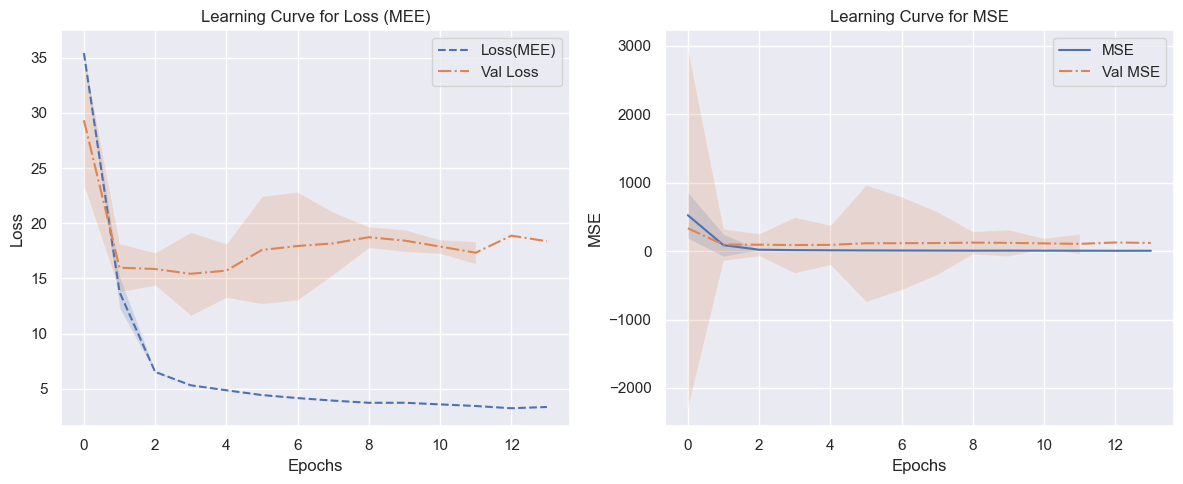

In [18]:
loss, val_loss, mee, val_mee = [], [], [], []

for i in range(len(train_scores_df)):
    loss.append(train_scores_df.iloc[i]['loss'])
    val_loss.append(train_scores_df.iloc[i]['val_loss'])
    mee.append(train_scores_df.iloc[i]['mean_euclidean_error'])
    val_mee.append(train_scores_df.iloc[i]['val_mean_euclidean_error'])

df_loss = pd.DataFrame(loss).T
df_val_loss = pd.DataFrame(val_loss).T
df_mee = pd.DataFrame(mee).T
df_val_mee = pd.DataFrame(val_mee).T

mean_loss = df_loss.mean(axis=1)
var_loss = df_loss.std(axis=1)
mean_val_loss = df_val_loss.mean(axis=1)
var_val_loss = df_val_loss.std(axis=1)

mean_mee = df_mee.mean(axis=1)
var_mee = df_mee.std(axis=1)
mean_val_mee = df_val_mee.mean(axis=1)
var_val_mee = df_val_mee.std(axis=1)

plt.figure(figsize=(12, 5))

# loss and val_loss
plt.subplot(1, 2, 1)
plt.plot(mean_loss, label='Loss(MSE)', linestyle='--')
plt.fill_between(range(len(mean_loss)), mean_loss-var_loss, mean_loss+var_loss, alpha=0.2)
plt.plot(mean_val_loss, label='Val Loss', linestyle='-.')
plt.fill_between(range(len(mean_val_loss)), mean_val_loss-var_val_loss, mean_val_loss+var_val_loss, alpha=0.2)
plt.title('Learning Curve for Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# mse and val mse
plt.subplot(1, 2, 2)
plt.plot(mean_mee, label='MEE', linestyle='-')
plt.fill_between(range(len(mean_mee)), mean_mee-var_mee, mean_mee+var_mee, alpha=0.2)
plt.plot(mean_val_mee, label='Val MEE', linestyle='-.')
plt.fill_between(range(len(mean_val_mee)), mean_val_mee-var_val_mee, mean_val_mee+var_val_mee, alpha=0.2)
plt.title('Learning Curve for MEE')
plt.xlabel('Epochs')
plt.ylabel('MEE')
plt.legend()

plt.tight_layout()
save_plot(plt, IMAGES_FOLDER, f'learning_curve_nn_cup_optuna_{METRIC}')
plt.show()

# Test of the model

In [19]:
y_pred_ensemble = np.zeros_like(y_test)

for model in final_model:
    y_pred = model.predict(X_test)
    y_pred_ensemble += y_pred

y_pred_ensemble /= len(final_model)

mee_ensemble = mean_euclidean_error(y_test, y_pred_ensemble)
r2_ensemble = multidim_r2(y_test, y_pred_ensemble)
rmse_ensemble = root_mean_squared_error(y_test, y_pred_ensemble)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)

print('Ensemble MEE:', mee_ensemble)
print('Ensemble R2:', r2_ensemble)
print('Ensemble RMSE:', rmse_ensemble)
print('Ensemble MSE:', mse_ensemble)


7/7 [==============================] - 0s 1ms/step
Ensemble MEE: 1.8881877176080752
Ensemble R2: 0.995065231803247
Ensemble RMSE: 1.407302248273537
Ensemble MSE: 1.980499617995752


## Ensamble of the final model using the whole dataset

In [20]:
"""l'Ensambling Può ridurre la varianza delle previsioni e migliorare la robustezza del modello alle fluttuazioni nei dati di training."""


# Cross-validation with the best parameters

i = 0
final_model_ = []
test_scores = []
for train_index, test_index in cv.split(X):
    X_train_1, X_test_1 = X[train_index], X[test_index]
    y_train_1, y_test_1 = y[train_index], y[test_index]
    i = i + 1

    # Generate 5 possible splits and foreach save a model and history

    pipeline_test = Pipeline([
        ('scaler', RobustScaler()),
        ('neuralnetwork', NeuralNetwork(verbose=0, **params, loss='mean_squared_error', validation_data=(X_test_1, y_test_1)))
    ])
    # save different model for each fold to make ensamble model later
    final_model_.append(pipeline_test.fit(X_train_1, y_train_1))
    test_scores.append(pipeline_test.named_steps['neuralnetwork'].history.history)

test_scores_df = pd.DataFrame(test_scores)



0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

0epoch [00:00, ?epoch/s]

# Save Model

In [21]:
# Save the model best parameters
best_params = params
best_params_df = pd.DataFrame([best_params])
csv_filename = os.path.join(MODEL_FOLDER,f'best_params_optuna_NN_{METRIC}.csv')
best_params_df.to_csv(csv_filename, index=False)


In [22]:
# Save the model
count_model = 0
for model in final_model:
    count_model += 1
    model_path = os.path.join(MODEL_FOLDER, f'NN_model_Optuna_NN_{METRIC}_model{count_model}.joblib')
    model_path_pkl = os.path.join(MODEL_FOLDER, f'NN_model_Optuna_NN_pkl_{METRIC}_model{count_model}.pkl')
    dump(model, model_path, compress=3)
    dump(model, model_path_pkl, compress=3)
count_model = 0
for model in final_model_ :
    count_model += 1
    model_path = os.path.join(MODEL_FOLDER, f'NN_model_Optuna_NN_{METRIC}_model{count_model}_final.joblib')
    model_path_pkl = os.path.join(MODEL_FOLDER, f'NN_model_Optuna_NN_pkl_{METRIC}_model{count_model}_final.pkl')
    dump(model, model_path, compress=3)
    dump(model, model_path_pkl, compress=3)



INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmph2l2t4bi\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmph2l2t4bi\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpxl_0g8se\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpxl_0g8se\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpm929nk1_\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpm929nk1_\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpl5w2_6w9\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpl5w2_6w9\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmptg5p6y44\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmptg5p6y44\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpxvzh3obe\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpxvzh3obe\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpabun0q2c\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpabun0q2c\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpw0w2v89q\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpw0w2v89q\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpdkdjf455\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpdkdjf455\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpqakw_3wx\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpqakw_3wx\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpjbnitc7q\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpjbnitc7q\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpp8cfgel8\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpp8cfgel8\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmp5fi9y_ex\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmp5fi9y_ex\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpndbrznhm\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpndbrznhm\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpdfhkfgx4\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpdfhkfgx4\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmp5a_f1z3l\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmp5a_f1z3l\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpaz3nq2r8\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpaz3nq2r8\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpd3h20n7t\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpd3h20n7t\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpaddnfvxi\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpaddnfvxi\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpo2kmfgsw\assets


INFO:tensorflow:Assets written to: C:\Users\N97CA~1.CAN\AppData\Local\Temp\tmpo2kmfgsw\assets
